# In this notebook
I look at constructing a simple matching score based on surrounding neighbors. The general idea is that good matches will have similar neighbors, and that we can further refine matches from there.

In [1]:
# Import all dependencies
import os
import numpy as np
from multiprocessing import Pool
from matplotlib import pyplot as plt
import geopandas as gpd
from scipy.spatial.distance import hamming as hamming_loss

import torch
from torch.utils.data import Dataset

# 1. Load the source images

In [2]:
file_path = '/datacommons/carlsonlab/zdc6/cs590/land_use/train'
imgs = os.listdir(os.path.join(file_path, 'img'))


class OneHotImages(Dataset):
    def __init__(self, file_path, files = None, transforms=None):
        self.file_path = file_path

        # Images
        if files is None:
            self.files = os.listdir(os.path.join(file_path, "img"))
        else:
            self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = torch.load(os.path.join(self.file_path, "img", self.files[idx]))

        with open(
            os.path.join(self.file_path, "labels", self.files[idx][:-3] + ".txt")
        ) as fp:
            label = float(fp.read())
        # Omit the tree class
        return img.numpy(), self.files[idx], label
    
# We only need the training data
train = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train")

# 2. Load the traversal data

In [4]:
# Get traversal data for PM_traversal.
traversal_path = '/datacommons/carlsonlab/zdc6/uhi/data/traverses/pm_trav.shp'
df = gpd.read_file(traversal_path)
df.head()

,datetime,temp_f,hi_f,rh,file,kmph,trav_id,geometry
0,2021-07-23 19:00:00,83.68,85.13,51.94,1006_230721_225132.000_0.csv,19.24,pm,POINT (-78.58891 35.87446)
1,2021-07-23 19:00:01,83.68,85.13,51.94,1006_230721_225132.000_0.csv,26.87,pm,POINT (-78.58885 35.87452)
2,2021-07-23 19:00:02,83.68,85.13,51.94,1006_230721_225132.000_0.csv,30.27,pm,POINT (-78.58880 35.87458)
3,2021-07-23 19:00:03,83.68,85.13,51.94,1006_230721_225132.000_0.csv,32.32,pm,POINT (-78.58873 35.87465)
4,2021-07-23 19:00:04,83.68,85.13,51.94,1006_230721_225132.000_0.csv,33.93,pm,POINT (-78.58867 35.87472)


# 3. For each of the images, calculate the average temperature for the k nearest neighbors

In [7]:
# Only keep Raleigh points
# df = df[df['geometry'].y < 35.9]
# print(len(df))
# Convert to meters
df = df.to_crs(epsg=3857)

In [6]:
print(len(train))

941


In [9]:
# Create dictionary mapping from ID to nearest neighbor temperature
nn_temp_map = {}
match_value = []

for i, (img, file_name, actual_temp) in enumerate(train):
    if i % 100 == 0:
        print(f'Finished {i} of {len(train)}')
    point_id = int(file_name.split("_")[-1].split(".")[0])
    
    # Get the poitn
    point = df.iloc[point_id]
    
    # Get all points close to that point ID
    df['dist'] = np.sqrt((df.geometry.x - point.geometry.x)**2 + (df.geometry.y - point.geometry.y)**2)
    
    # Calculate the prog score
    sort_arr = df[df['dist'] > 600] # Must be at least 600 meters away (to be far enough away from the point)
    prog_score = sort_arr.sort_values('dist')[0:10]['temp_f'].mean()
    
    # Append value
    match_value.append(prog_score)
    
    nn_temp_map[str(point_id)] = prog_score

Finished 0 of 941
Finished 100 of 941
Finished 200 of 941
Finished 300 of 941
Finished 400 of 941
Finished 500 of 941
Finished 600 of 941
Finished 700 of 941
Finished 800 of 941
Finished 900 of 941


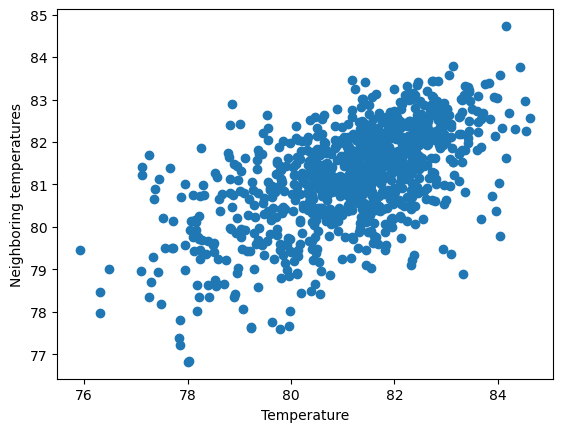

In [10]:
# Let's visualize the relationship between the match values and the
# actual temperature observed
actual_temps = []
for i in range(len(train)):
#     if i % 100 == 0:
#         print(f'Finished {i} of {len(train)}')
    point_id = int(train[i][1].split("_")[-1].split(".")[0])
    
    actual_temps.append(train[i][2])
    
plt.scatter(actual_temps, match_value)
plt.xlabel("Temperature")
plt.ylabel("Neighboring temperatures")
plt.show()

In [14]:
# Remove the distance column after the last run
df.drop(columns='dist', inplace=True)

# 4. Create the bins, and match on specific values

In [19]:
match_value = np.array(match_value)

In [94]:
distance = 10
treatment = 0   # 0 is roughly concrete, 1 is grass, 2 is trees, 3 is building? this isn't exact
control = 2
treatment_pctg = 0.9
control_pctg = 0.9

In [95]:
# Define the treatment distance in pixels, the class of interest, 
# and the percentage greater than for the treatment, and percentage less than
# for the control
import time
def create_treatment_and_control_groups(distance, treatment, control, treatment_pctg, control_pctg):
    # Add files to this list for matching
    start = time.time()
    
    treatment_group = []
    control_group = []
    
    # Set a few variables
    w, h, _ = train[0][0].shape

    # Look at each image and file into the categories
    for (img, file_name, label), mv in zip(train, match_value): 
        # Look at pixels in the middle of the image
        area = img[w//2 - distance:w//2 + distance, h//2 - distance:h//2 + distance, :]

        if area[:, :, treatment].mean() > treatment_pctg:
            treatment_group.append((img, file_name, label, mv))

        if area[:, :, control].mean() > control_pctg:
            control_group.append((img, file_name, label, mv))
    
    print(f"{time.time() - start} seconds")
    
    return treatment_group, control_group

In [96]:
treatment, control = create_treatment_and_control_groups(distance, treatment, control, treatment_pctg, control_pctg)


9.02227258682251 seconds


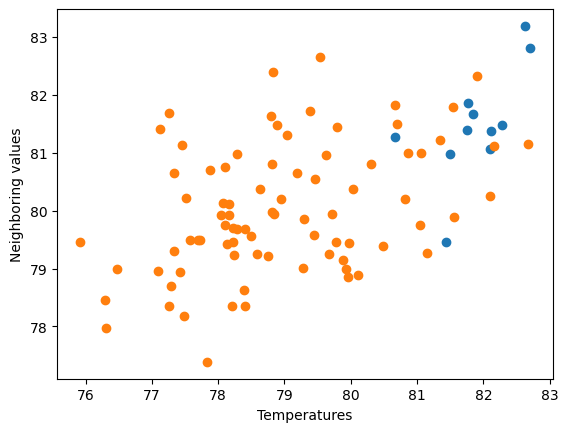

In [42]:
# Let's plot the relationship between the observed values and the
# match values
tr_vals = [t[2] for t in treatment]
tr_neighbors = [t[3] for t in treatment]

co_vals = [c[2] for c in control]
co_neighbors = [c[3] for c in control]

plt.scatter(tr_vals, tr_neighbors)
plt.scatter(co_vals, co_neighbors)
plt.xlabel("Temperatures")
plt.ylabel("Match values")
plt.show()

In [ ]:
# Define the filter function to get the set of controls
from functools import partial
def get_match_value(radius, treatment_val, control_val):
    if abs(treatment_val - control_val[3]) < radius:
        return True
    return False

In [105]:
match_radius = 1 # Temperatures within which the match should fall
treatment_vals = []
control_vals = []
for t_img, _, label, mv, in treatment:
    # Get candidates within the radius
    get_control = partial(get_match_value, match_radius, mv)
    valid_controls = list(filter(get_control, control))
    
    if len(valid_controls) == 0:
        continue
    else:
        treatment_vals.append(label)
        
    # Get closest hamming distance values
    best_hamming = 1
    best_temp = 0
    for c_img, _, c_temp, _ in valid_controls:
        sim = hamming_loss(t_img.flatten(), c_img.flatten())

        if sim < best_hamming:
            best_hamming = sim
            best_temp = c_temp
    control_vals.append(best_temp)

In [106]:
print(len(treatment_vals))

11


# Calculate the average treatment effect

In [107]:
ate = np.mean(treatment_vals) - np.mean(control_vals)
print(f"The ATE is {ate:.2f} degrees Fahrenheit.")

The ATE is 1.37 degrees Fahrenheit.
